# Evaluation of the predictive capabilities of select brain attributes for sex and age
The topic of whether or not there is a typical "male" and "female" brain is hotly contested. Several studies, including [Sex beyond the genitalia: The human brain mosaic](https://www.pnas.org/content/112/50/15468) and [Multivariate revisit to “sex beyond the genitalia”](https://www.pnas.org/content/113/14/E1966) have used a mosaic of various brain features to try and answer this question, with conflicting results.

One of the potential problems that arise from previous mosaic analysis is that they use the absolute volume of various features of the brain without taking into account that the mean size of a male person's brain is larger than a female person's brain because on average males are larger than females.

In this analysis, we explore if normalizing the volumes of the various brain regions to percentages of the total brain volume makes male and female brains less differentiable.

In addition, we also seek to answer if a different set of brain features can perform better at categorizing male and female brains. The features we use in this analysis are the connectomes of various brain regions.

Finally, we seek to answer if we can use volume or connectome features to predict whether or not participants fall into certain age ranges.

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import sklearn.linear_model as linear_model
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split

In [66]:
# Define figure saving variables.
figsize = (10, 5)
save_name = 'images/{}.png'

## Brain Region Volumes as Predictive Features
The NKI_SBA_Volume dataset contains the volumes of various regions of the brain for each participant in the study as well as the total volume of each brain. We want to know how well a logistic regression model that uses these volume features does at categorizing male and female brains and if brains fall into certain age groups when the volumes are unnormalized vs when the volumes are normalized as percentages of total brain volume.

### Predicting Sex

#### Distributions of Total Volume

In [67]:
df = pd.read_hdf('NKI_SBA_Volume.hdf5', key='NKI')

Extract the volume variables from the variables in the data set. There are 69 variables that give the volume of various brain regions for each participant.

In [68]:
features = [name for name in df.columns if name.endswith('volume')]
len(features)

69

Below is the distribution of total brain volumes for all participants.

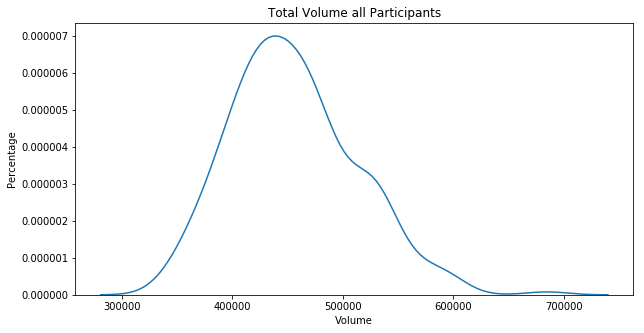

In [69]:
var = 'total_volume'
plt.figure(figsize=figsize)
sns.kdeplot(df[var].values);
plt.title('Total Volume all Participants')
plt.xlabel('Volume')
plt.ylabel('Percentage')
plt.savefig(save_name.format('total_volume_dist'))

Below are the distributions of total brain volumes for male and female subjects. As expected, men have bigger brains on average. The female brain distribution is less variable than the male distribution.

Male mean: 487165.6116504854	 Female mean: 435993.4082840237
Male std: 56016.24775538615	 Female std: 48148.529005421165


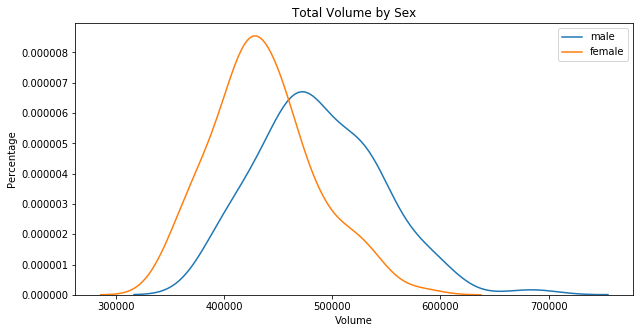

In [70]:
male = df['bio_sex'] == 0
female = df['bio_sex'] == 1

plt.figure(figsize=figsize)
sns.kdeplot(df.loc[male, var], label='male')
sns.kdeplot(df.loc[female, var], label='female');
plt.title("Total Volume by Sex")
plt.xlabel('Volume')
plt.ylabel('Percentage')
plt.savefig(save_name.format('total_volume_sex'))

m_mean = df.loc[male, var].mean()
m_std = df.loc[male, var].std()

f_mean = df.loc[female, var].mean()
f_std = df.loc[female, var].std()

print("Male mean: {}\t Female mean: {}\nMale std: {}\t Female std: {}".format(m_mean, f_mean, m_std, f_std))

#### Cohen Effect Size for Unnormalized Volumes

We first look at the unnormalized brain region volumes and how well they do at predicting if a brain is male or female.

To understand which variables will be the best for predicting male and female brains, we list the variables with the largest Cohen Effect size between the male and female groups.

In [71]:
def cohen_effect_size(group1, group2):
    """Compute Cohen's effect size (d).

    group1: Series or NumPy array
    group2: Series or NumPy array

    returns: float
    """
    diff = group1.mean() - group2.mean()

    n1, n2 = len(group1), len(group2)
    var1 = group1.var()
    var2 = group2.var()

    pooled_var = (n1 * var1 + n2 * var2) / (n1 + n2)
    d = diff / np.sqrt(pooled_var)
    return d

In [72]:
def compute_cohen_effect(df, features):
    res = pd.Series()

    grouped = df.groupby('bio_sex')
    for var in features:
        groups = grouped[var]
        female = groups.get_group(1)
        male = groups.get_group(0)
        d = cohen_effect_size(male, female)
        res[var] = d
        
    return res

Below are the top features by Cohen effect size. The variable with the largest effect size is the total volume, which is expected given the distributions shown above. It is likely that the other top features are strongly correlated with the total volume.

In [73]:
num_features = 12

res = compute_cohen_effect(df, features)
top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]
print(top_by_cohen)

total_volume                      0.998091
rh_superiorfrontal_volume         0.970546
rh_inferiortemporal_volume        0.964111
rh_lateraloccipital_volume        0.960110
rh_precuneus_volume               0.958064
lh_middletemporal_volume          0.953209
lh_superiorfrontal_volume         0.941572
lh_medialorbitofrontal_volume     0.937211
rh_rostralmiddlefrontal_volume    0.927699
lh_inferiortemporal_volume        0.909025
rh_fusiform_volume                0.890256
rh_lateralorbitofrontal_volume    0.874188
dtype: float64


In [74]:
print(res.mean())

0.6520597237484246


Below is the distribution of the variable with the second highest cohen effect size. Note the similarity in the shape of the distributions to the shapes of the distributions of the total volumes.

Male mean: 22546.252427184467	 Female mean: 19911.8224852071
Male std: 3165.7150160914352	 Female std: 2397.998965748214


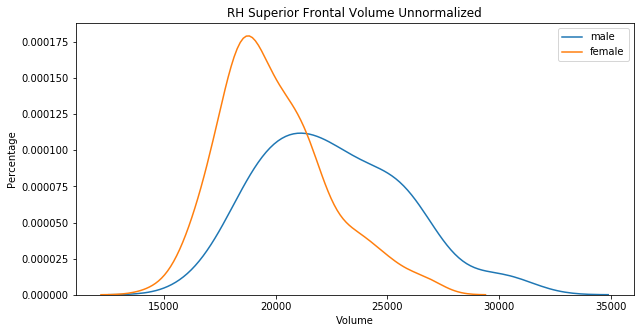

In [75]:
var = 'rh_superiorfrontal_volume'
plt.figure(figsize=figsize)
sns.kdeplot(df.loc[male, var], label='male')
sns.kdeplot(df.loc[female, var], label='female');
plt.title('RH Superior Frontal Volume Unnormalized')
plt.xlabel('Volume')
plt.ylabel('Percentage')
plt.savefig(save_name.format('rh_superior_volume_unnorm'))

m_mean = df.loc[male, var].mean()
m_std = df.loc[male, var].std()

f_mean = df.loc[female, var].mean()
f_std = df.loc[female, var].std()

print("Male mean: {}\t Female mean: {}\nMale std: {}\t Female std: {}".format(m_mean, f_mean, m_std, f_std))

#### Cohen Effect Size for Normalized Volumes

Now, we express the volumes of the brain regions as percentages of the total volume in order to remove the effect of the total brain size on our predictive model. This will give us insight into how much the total volume affects the other volume variables.

In [76]:
features_norm = [name for name in df.columns if name.endswith('norm')]
len(features)

69

#### Cohen Effect Sizes for Unnormalized Volume Features
Below are the features with the largest Cohen effect size when we normalize for total volume. Note that the effect sizes are less than half of the top effect sizes without normalization. Additionally, the top features are not in the same order, nor are they all the same as the top features without normalization.

In [77]:
num_features = 12

res = compute_cohen_effect(df, features_norm)
top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]
top_by_cohen

/home/eprice/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


lh_middletemporal_volume_norm          0.416500
rh_inferiortemporal_volume_norm        0.378245
lh_rostralmiddlefrontal_volume_norm    0.337220
rh_rostralmiddlefrontal_volume_norm    0.305688
rh_middletemporal_volume_norm          0.300476
lh_inferiortemporal_volume_norm        0.278646
lh_medialorbitofrontal_volume_norm     0.259600
rh_precuneus_volume_norm               0.249023
lh_parsorbitalis_volume_norm           0.234720
lh_supramarginal_volume_norm           0.205109
rh_parsorbitalis_volume_norm           0.189739
rh_inferiorparietal_volume_norm        0.184604
dtype: float64

In [78]:
print(res.mean())

-0.03609959819259549


Below are the distributions of the feature with the highest Cohen effect size for male and female brains. Note that the shapes of the male and female distributions are more similar, and that they have very similar standard deviations, unlike the unnormalized features.

Male mean: 0.023592512193514943	 Female mean: 0.02266080499776618
Male std: 0.002321341127801927	 Female std: 0.002183987780623692


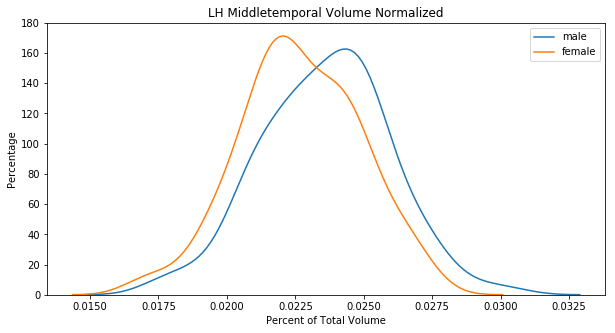

In [79]:
var = 'lh_middletemporal_volume_norm'
plt.figure(figsize=figsize)
sns.kdeplot(df.loc[male, var], label='male')
sns.kdeplot(df.loc[female, var], label='female');
plt.title('LH Middletemporal Volume Normalized')
plt.xlabel('Percent of Total Volume')
plt.ylabel('Percentage')
plt.savefig(save_name.format('lh_middletemporal_volume_norm'))

m_mean = df.loc[male, var].mean()
m_std = df.loc[male, var].std()

f_mean = df.loc[female, var].mean()
f_std = df.loc[female, var].std()

print("Male mean: {}\t Female mean: {}\nMale std: {}\t Female std: {}".format(m_mean, f_mean, m_std, f_std))

Male mean: 0.046243161779930174	 Female mean: 0.04570558406919973
Male std: 0.0031891334926169314	 Female std: 0.002731352398352888


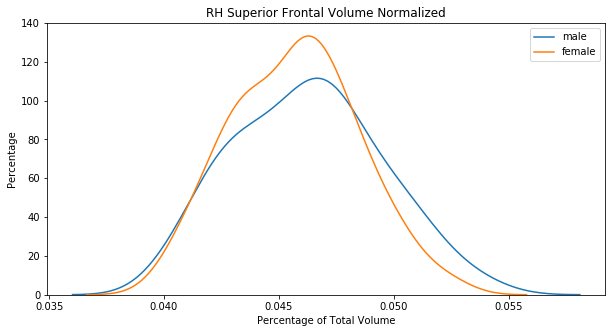

In [80]:
var = 'rh_superiorfrontal_volume_norm'
plt.figure(figsize=figsize)
sns.kdeplot(df.loc[male, var], label='male')
sns.kdeplot(df.loc[female, var], label='female');
plt.title('RH Superior Frontal Volume Normalized')
plt.xlabel('Percentage of Total Volume')
plt.ylabel('Percentage')
plt.savefig(save_name.format('rh_superior_volume_norm'))

m_mean = df.loc[male, var].mean()
m_std = df.loc[male, var].std()

f_mean = df.loc[female, var].mean()
f_std = df.loc[female, var].std()

print("Male mean: {}\t Female mean: {}\nMale std: {}\t Female std: {}".format(m_mean, f_mean, m_std, f_std))

#### Logistic Regression with Unnormalized Volume Features

Now, we use a logistic regression model using the unnormalized features to categorize male and female brains. Although the model does better than chance, the area under the ROC curve is only 0.72, the R^2 value is 0.67, and the RMSE is 0.57. The RMSE is very high considering that the range of values the model can output are only between 0 and 1. So, this is not a robust model for differentiating male and female brains.

/home/eprice/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.6707317073170732
Root Mean Squared Error: 0.5738190417570045
0.7215354586857515
[[15 14]
 [13 40]]


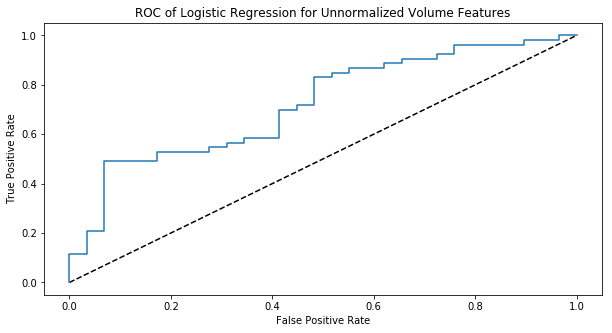

In [81]:
y = df['bio_sex']
X = df.drop(list(set(df.columns).difference(set(features))), axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Unnormalized Volume Features")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.savefig(save_name.format('roc_vol_unnorm'))
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

#### Logistic Regression with Normalized Volume Features

Now, we use the normalized features in the logistic regression model to predict if a brain is male or female. Although the area under the ROC is slightly larger, the R^2 value and RMSE are both slightly larger, so this model is also not a robust model for differentiating male and female brains.

/home/eprice/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.6463414634146342
Root Mean Squared Error: 0.59469196781642
0.7807417046193884
[[ 0 29]
 [ 0 53]]


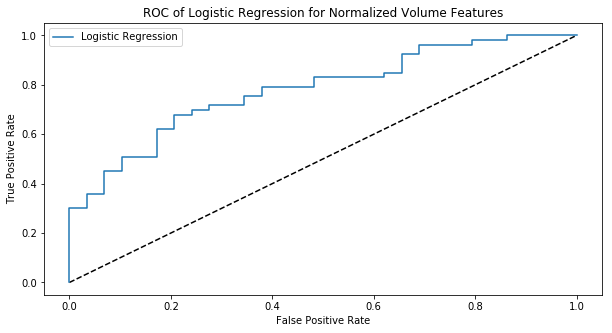

In [82]:
y = df['bio_sex']
X = df.drop(list(set(df.columns).difference(set(features_norm))), axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Normalized Volume Features")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(save_name.format('roc_vol_norm'))
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

### Predicting Age for the Interquartile Age Range
In addition to sex, we want to see if the volume features can be used to predict the age of a participant. To do this, we split the participants into a "young" group and an "old" group, where the cutoff is the median age.

First, we only look at the participants that fall into the interquartile range. This is because there is a very large age range in the data, and we want to restrict our categorizations so that we aren't grouping 12 year olds with 30 year olds. Our "young" group includes participants age 26-49, and our "old" group contains participants ages 50 to 60.

In [83]:
df['age'].describe()

count    272.000000
mean      45.783088
std       18.861331
min       12.000000
25%       26.000000
50%       49.000000
75%       60.000000
max       85.000000
Name: age, dtype: float64

#### Distribution of Total Volume
Below are the distributions of the total volumes of the brains of the "old" group, the "young" group, and all participants, including those outside of the IQR. Although it appears that the young group has on average slightly larger brains than the old group, the difference between the distributions is smaller than when participants are grouped by sex.

/home/eprice/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Young mean: 457430.43209876545	Young std: 46434.07644013668
Old mean: 427340.7704918033	Old std: 45965.3628418158


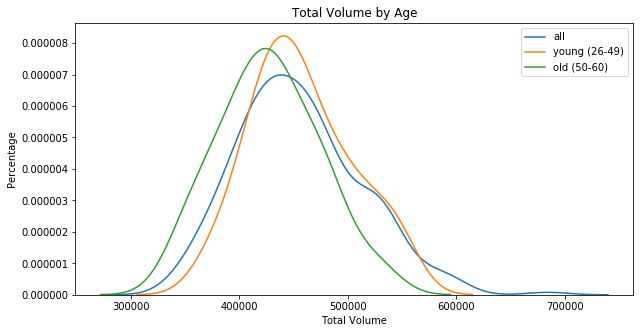

In [84]:
var = 'total_volume'

plt.figure(figsize=figsize)
sns.kdeplot(df[var].values, label='all');

young = (df['age'] <= 49) & (df ['age'] >= 26)
old = (df['age'] > 49) & (df['age'] <= 60)

sns.kdeplot(df.loc[young, var], label='young (26-49)')
sns.kdeplot(df.loc[old, var], label='old (50-60)');
plt.title("Total Volume by Age")
plt.xlabel("Total Volume")
plt.ylabel("Percentage")
plt.savefig(save_name.format('age_total_vol_dist'))

young_mean = df.loc[young, var].mean()
young_std = df.loc[young, var].std()
old_mean = df.loc[old, var].mean()
old_std = df.loc[old, var].std()

print("Young mean: {}\tYoung std: {}\nOld mean: {}\tOld std: {}".format(young_mean, young_std, old_mean, old_std))

In [85]:
# Group participants into age groups.
# Participants outside the age range are assigned NaNs for the new variable.
conditions = [
    (df['age'] <= 49) & (df['age'] >= 26),
    (df['age'] <= 60) & (df['age'] > 49)]
choices = [1, 0]
df['young'] = np.select(conditions, choices, default=np.nan)
df['young'].mean()

0.5704225352112676

In [86]:
def compute_cohen_effect_age(df, features):
    res = pd.Series()

    grouped = df.groupby('young')
    for var in features:
        groups = grouped[var]
        young = groups.get_group(1)
        old = groups.get_group(0)
        d = cohen_effect_size(young, old)
        res[var] = d
        
    return res

#### Cohen Effect Size for Unnormalized Volume Features
Here, we list the features with the largest Cohen effect size between the groups. In this case, even though the volumes are not normalized, the total volume does not have the largest effect size, which could be a signal that normalizing for it will not make a large difference in the predictive abilities of the logistic regression models.

In [87]:
num_features = 12

res = compute_cohen_effect_age(df, features)

top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]
print(top_by_cohen)

rh_medialorbitofrontal_volume     0.761393
lh_parstriangularis_volume        0.740418
lh_lateralorbitofrontal_volume    0.717843
lh_rostralmiddlefrontal_volume    0.712378
rh_posteriorcingulate_volume      0.692557
rh_inferiorparietal_volume        0.680425
rh_parstriangularis_volume        0.661210
rh_parsopercularis_volume         0.661119
rh_superiorfrontal_volume         0.659108
total_volume                      0.650822
lh_middletemporal_volume          0.633724
lh_parsopercularis_volume         0.630243
dtype: float64


In [88]:
print(res.mean())

0.4289081780693683


Below we visualize the distributions of the feature with the largest effect size. There is significant overlap between the distributions.

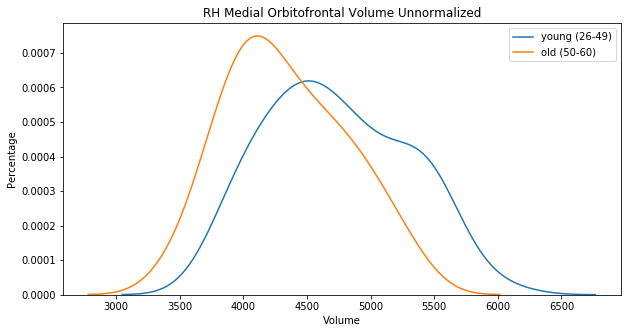

In [89]:
young = df['young'] == 1
old = df['young'] == 0

var = 'rh_medialorbitofrontal_volume'

plt.figure(figsize=figsize)
sns.kdeplot(df.loc[young, var], label='young (26-49)')
sns.kdeplot(df.loc[old, var], label='old (50-60)');
plt.title("RH Medial Orbitofrontal Volume Unnormalized")
plt.xlabel("Volume")
plt.ylabel("Percentage")
plt.savefig(save_name.format('rh_medialorbitio_unnorm_age'))

#### Cohen Effect Size for Normalized Volume Features
Now, we list the normalized volume features with the largest effect size. Although all of the Cohen effect sizes have decreased, the drop is not as drastic as it was for when we were comparing male and female brains.

In [90]:
num_features = 12

res = compute_cohen_effect_age(df, features_norm)


top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]
print(top_by_cohen)

lh_rostralmiddlefrontal_volume_norm    0.475797
lh_parstriangularis_volume_norm        0.404769
rh_parsopercularis_volume_norm         0.342945
rh_transversetemporal_volume_norm      0.319506
rh_parstriangularis_volume_norm        0.311488
rh_inferiorparietal_volume_norm        0.301266
lh_middletemporal_volume_norm          0.300623
rh_posteriorcingulate_volume_norm      0.299719
rh_bankssts_volume_norm                0.296518
lh_parsopercularis_volume_norm         0.234782
lh_caudalmiddlefrontal_volume_norm     0.228521
lh_lateralorbitofrontal_volume_norm    0.225363
dtype: float64


/home/eprice/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


In [91]:
print(res.mean())

-0.009188259728486626


Again, we visualize the distributions for the feature with the largest Cohen effect size. Again, there is considerable overlap between the old and young groups.

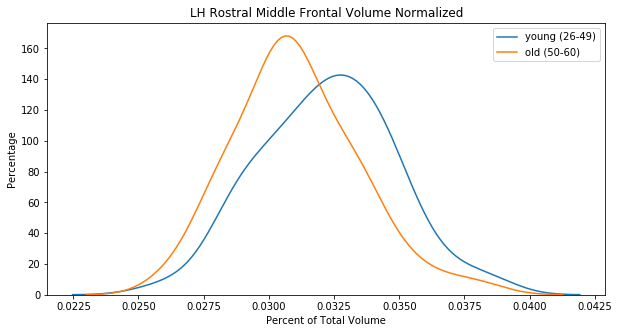

In [38]:
young = df['young'] == 1
old = df['young'] == 0

var = 'lh_rostralmiddlefrontal_volume_norm'

plt.figure(figsize=figsize)
sns.kdeplot(df.loc[young, var], label='young (26-49)')
sns.kdeplot(df.loc[old, var], label='old (50-60)');
plt.title("LH Rostral Middle Frontal Volume Normalized")
plt.xlabel("Percent of Total Volume")
plt.ylabel("Percentage")
plt.savefig(save_name.format('lh_rostralmiddlefrontal_norm_age'))

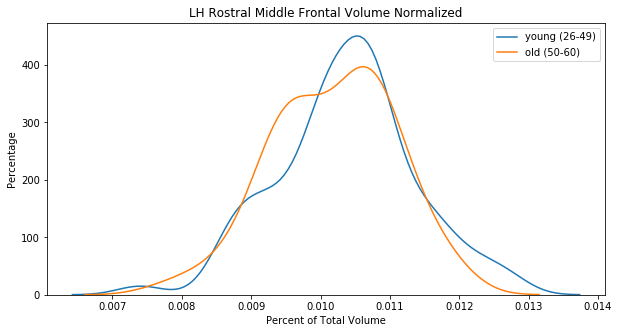

In [59]:
young = df['young'] == 1
old = df['young'] == 0

var = 'rh_medialorbitofrontal_volume_norm'

plt.figure(figsize=figsize)
sns.kdeplot(df.loc[young, var], label='young (26-49)')
sns.kdeplot(df.loc[old, var], label='old (50-60)');
plt.title("LH Rostral Middle Frontal Volume Normalized")
plt.xlabel("Percent of Total Volume")
plt.ylabel("Percentage")
plt.savefig(save_name.format('lh_rostralmiddlefrontal_norm_age'))

#### Logistic Regression with Unnormalized Volume Features
Now, we look at the performance of a logistic regression model categorizing brains into the young and old groups. In this case, the model behaves extremely poorly, with an area under the ROC of .52, which is basically random chance. So, we can fairly definitely conclude that the unnormalized volume features are not suitable for predicting the age groups we defined.

/home/eprice/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.5348837209302325
Root Mean Squared Error: 0.6819943394704735
0.533695652173913
[[ 8 12]
 [ 8 15]]


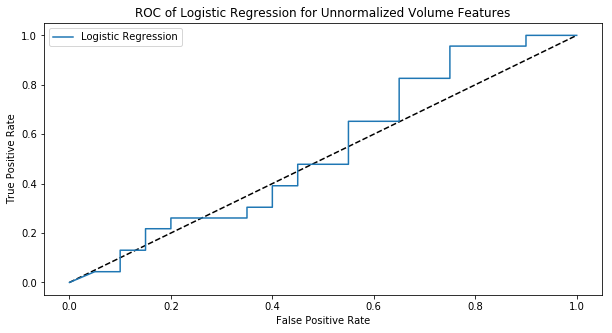

In [93]:
features.append('young')
temp = df.drop(list(set(df.columns).difference(set(features))), axis=1).dropna()
features.pop()


y = temp['young']
X = temp.drop('young', axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Unnormalized Volume Features")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(save_name.format('roc_vol_age_unnorm'))
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

#### Logistic Regression with Normalized Volume Features
Now, we use normalized volume features in our logistic regression model. For all of the metrics we evaluate the model on, this model appears to perform the same as the model trained on unnormalized features. This makes sense because the Cohen effect size between the age groups for total volume was smaller than the effect size between the male and female groups.

/home/eprice/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.5348837209302325
Root Mean Squared Error: 0.6819943394704735
0.5326086956521738
[[ 0 20]
 [ 0 23]]


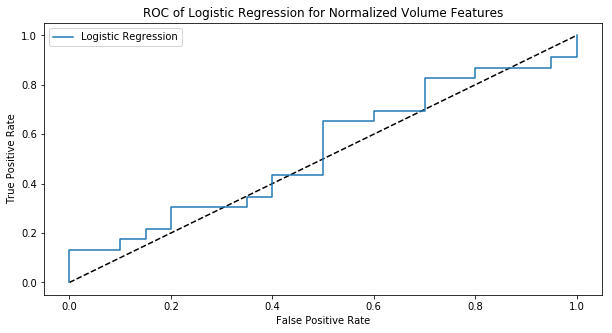

In [94]:
features_norm.append('young')
temp = df.drop(list(set(df.columns).difference(set(features_norm))), axis=1).dropna()
features_norm.pop()


y = temp['young']
X = temp.drop('young', axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Normalized Volume Features")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(save_name.format('roc_vol_norm_age'))
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

### Predicting Age for the Entire Age Range
Because the age groups we looked at in the previous section would all have adult brains that are finished growing, and the old group did not contain ages where we would expect to see brain deterioration due to age, it makes sense that the models could not differentiate the age groups. However, the entire age range in the data set, and the highest and lowest ages may change the predictive capabilities of the model. We want to know if the model does better when all ages are included in the young and old groups. Again, we place the upper threshold for the young group at the median age of 49.

In [41]:
df['age'].describe()

count    272.000000
mean      45.783088
std       18.861331
min       12.000000
25%       26.000000
50%       49.000000
75%       60.000000
max       85.000000
Name: age, dtype: float64

#### Distribution of Total Volume
Below are the distributions of total volume for each age group. There is still significant overlap between the groups, however the difference in means is larger than when the age groups were more restricted.

/home/eprice/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Young mean: 481108.9383561644	Young std: 55487.44418598431
Old mean: 425547.9285714286	Old std: 42132.38483811303


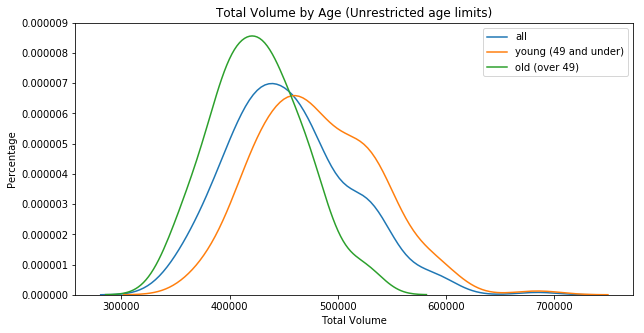

In [42]:
var = 'total_volume'

plt.figure(figsize=figsize)
sns.kdeplot(df[var].values, label='all');

young2 = df['age'] <= 49
old2 = df['age'] > 49

sns.kdeplot(df.loc[young2, var], label='young (49 and under)')
sns.kdeplot(df.loc[old2, var], label='old (over 49)');
plt.title("Total Volume by Age (Unrestricted age limits)")
plt.xlabel("Total Volume")
plt.ylabel("Percentage")
plt.savefig(save_name.format('age_total_vol_dist_all'))

young_mean = df.loc[young2, var].mean()
young_std = df.loc[young2, var].std()
old_mean = df.loc[old2, var].mean()
old_std = df.loc[old2, var].std()

print("Young mean: {}\tYoung std: {}\nOld mean: {}\tOld std: {}".format(young_mean, young_std, old_mean, old_std))

In [43]:
conditions = [
    (df['age'] <= 49),
    (df['age'] > 49)]
choices = [1, 0]
df['young2'] = np.select(conditions, choices, default=np.nan)
df['young2'].mean()

0.5367647058823529

#### Cohen Effect Sizes for Unnormalized Volume Features
Below we list the unnormalized volume features with the largest Cohen effect sizes. These are surprisingly slightly larger than the Cohen effect sizes between the male and female brains, which is promising for the capabilities of the model. Also, the total volume does not have the largest effect size, like with the more restricted age groups.

In [44]:
def compute_cohen_effect_age(df, features):
    res = pd.Series()

    grouped = df.groupby('young2')
    for var in features:
        groups = grouped[var]
        young = groups.get_group(1)
        old = groups.get_group(0)
        d = cohen_effect_size(young, old)
        res[var] = d
        
    return res

In [45]:
num_features = 12

res = compute_cohen_effect_age(df, features)

top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]

print(top_by_cohen)

lh_superiorfrontal_volume         1.192475
lh_lateralorbitofrontal_volume    1.145116
rh_superiorfrontal_volume         1.126841
lh_rostralmiddlefrontal_volume    1.125618
total_volume                      1.116835
rh_bankssts_volume                1.089253
lh_parstriangularis_volume        1.079199
rh_parsopercularis_volume         1.071623
rh_inferiorparietal_volume        1.066946
lh_middletemporal_volume          1.063581
rh_parstriangularis_volume        1.044952
rh_lateralorbitofrontal_volume    1.027525
dtype: float64


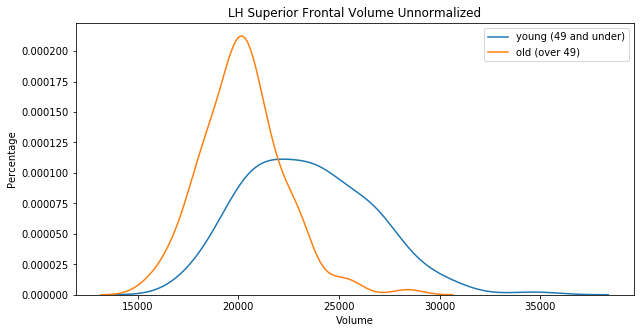

In [46]:
young = df['young2'] == 1
old = df['young2'] == 0

var = 'lh_superiorfrontal_volume'

plt.figure(figsize=figsize)
sns.kdeplot(df.loc[young, var], label='young (49 and under)')
sns.kdeplot(df.loc[old, var], label='old (over 49)');
plt.title("LH Superior Frontal Volume Unnormalized")
plt.xlabel("Volume")
plt.ylabel("Percentage")
plt.savefig(save_name.format('lh_superiorfrontal_unnorm_age_all'))

#### Cohen Effect Size for Normalized Volume Features
Now, we compute the Cohen effect sizes for the normalized volume features. The effect sizes have all decreased, but they are larger than for the more restricted age groups.

In [47]:
num_features = 12

res = compute_cohen_effect_age(df, features_norm)

top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]
print(top_by_cohen)

lh_rostralmiddlefrontal_volume_norm    0.629192
rh_bankssts_volume_norm                0.493653
rh_parsopercularis_volume_norm         0.466349
lh_middletemporal_volume_norm          0.461419
lh_parstriangularis_volume_norm        0.457526
rh_inferiorparietal_volume_norm        0.400318
rh_middletemporal_volume_norm          0.389172
rh_parstriangularis_volume_norm        0.375779
lh_superiorfrontal_volume_norm         0.374386
rh_parsorbitalis_volume_norm           0.352402
lh_bankssts_volume_norm                0.323629
lh_superiortemporal_volume_norm        0.296492
dtype: float64


/home/eprice/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in double_scalars
  app.launch_new_instance()


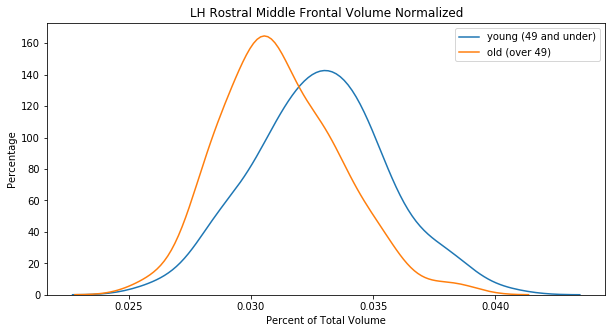

In [48]:
young = df['young2'] == 1
old = df['young2'] == 0

var = 'lh_rostralmiddlefrontal_volume_norm'

plt.figure(figsize=figsize)
sns.kdeplot(df.loc[young, var], label='young (49 and under)')
sns.kdeplot(df.loc[old, var], label='old (over 49)');
plt.title("LH Rostral Middle Frontal Volume Normalized")
plt.xlabel("Percent of Total Volume")
plt.ylabel("Percentage")
plt.savefig(save_name.format('lh_rostralmiddlefrontal_norm_age_all'))

#### Logistic Regression for Unnormalized Volume Features
Not surprisingly, our model performs much better for the age groups now that they contain larger age ranges. The metrics we evaluate the model on are comparable to the models that categorize male and female brains.

/home/eprice/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.6951219512195121
Root Mean Squared Error: 0.5521576303742327
0.7490808823529411
[[25  9]
 [16 32]]


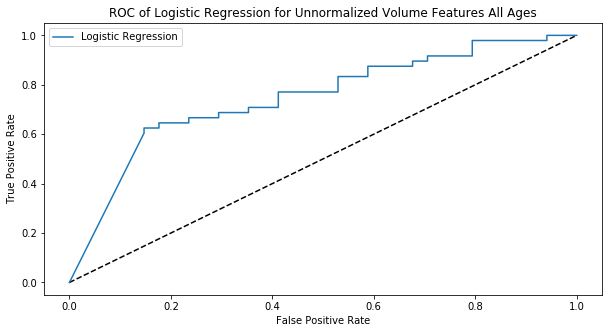

In [49]:
features.append('young2')
temp = df.drop(list(set(df.columns).difference(set(features))), axis=1).dropna()
features.pop()


y = temp['young2']
X = temp.drop('young2', axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Unnormalized Volume Features All Ages")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(save_name.format('roc_vol_age_unnorm_all'))
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

#### Logistic Regression for Normalized Volume Features
The model that uses the normalized volume features performs about the same for the metrics we evaluate it on as the previous model, which is unsurprising considering that total volume did not have the largest effect size between groups.

/home/eprice/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.5853658536585366
Root Mean Squared Error: 0.6439209162167846
0.7481617647058824
[[ 0 34]
 [ 0 48]]


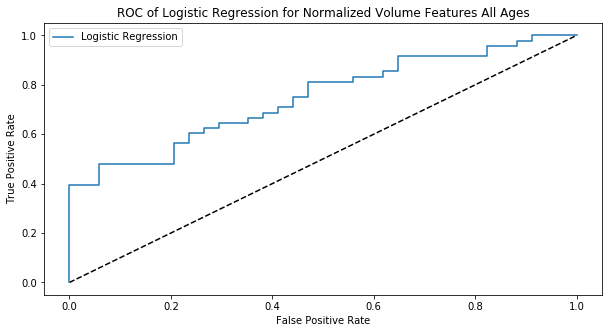

In [50]:
features_norm.append('young2')
temp = df.drop(list(set(df.columns).difference(set(features_norm))), axis=1).dropna()
features_norm.pop()


y = temp['young2']
X = temp.drop('young2', axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Normalized Volume Features All Ages")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(save_name.format('roc_vol_age_norm_all'))

                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

## Connectomes as Predictive Features

The 1000_Connectomes_age_18-26_VBM dataset contains connectome values for various regions of the brain and the sex and age of each participant. We want to see if these features perform better as predictors of sex and age than the volume features. In this case, we are not normalizing the features because we don't have a reference point to normalize to.

In [104]:
df_1000 = pd.read_hdf('1000_Connectomes_age_18-26_VBM.hdf5', key='VBM')

### Predicting Sex

Below are the features that have the largest Cohen effect sizes between the male and female groups. None of the effect sizes are very large, so this may indicate that connectomes will not hold much predictive power in a model.

In [105]:
def compute_cohen_effect(df, features):
    res = pd.Series()

    grouped = df.groupby('bio_sex')
    for var in features:
        groups = grouped[var]
        male = groups.get_group(1)
        female = groups.get_group(0)
        d = cohen_effect_size(male, female)
        res[var] = d
        
    return res

In [106]:
num_features = 12
features = list(df_1000.drop(['age', 'bio_sex'], axis=1).columns)

res = compute_cohen_effect(df_1000, features)
top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]
print(top_by_cohen)

vermis_7             0.601494
hippocampus_r        0.576675
caudate_l            0.537445
cerebelum_crus2_r    0.503056
postcentral_r        0.488203
hippocampus_l        0.462809
frontal_inf_orb_l    0.456477
frontal_sup_orb_l    0.455499
cerebelum_crus2_l    0.449714
parietal_inf_r       0.429542
postcentral_l        0.427087
frontal_mid_orb_l    0.425625
dtype: float64


In [113]:
print(res.mean())

0.2477823626145261


In [114]:
male = df_1000['bio_sex'] == 0
female = df_1000['bio_sex'] == 1

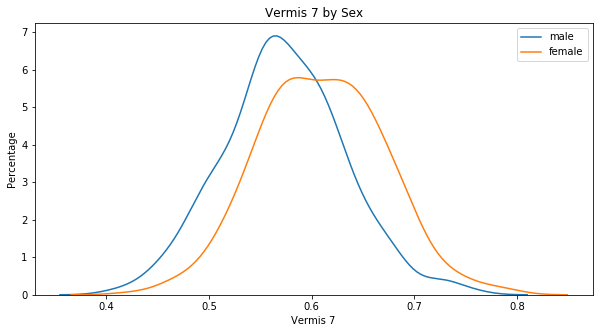

In [115]:
var = 'vermis_7'
plt.figure(figsize=figsize)
sns.kdeplot(df_1000.loc[male, var], label='male')
sns.kdeplot(df_1000.loc[female, var], label='female');
plt.title("Vermis 7 by Sex")
plt.xlabel('Vermis 7')
plt.ylabel('Percentage')
plt.savefig(save_name.format('verm_sex'))

The predictive model performs about as well as the predictive models that used volume features. The RMSE value is concerningly high (0,6) considering that the model makes a choice between 0 and 1.

/home/eprice/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.6276595744680851
Root Mean Squared Error: 0.6101970382851059
0.727038727038727
[[ 15  62]
 [  8 103]]


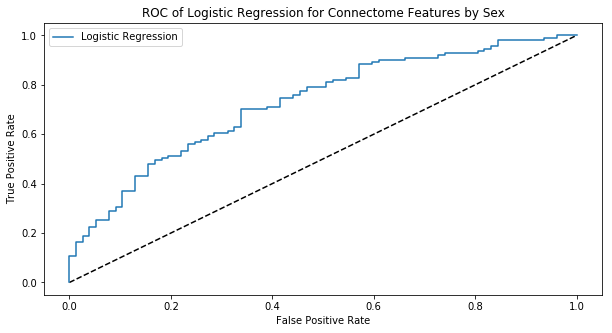

In [116]:
features.append('bio_sex')
temp = df_1000.drop(list(set(df_1000.columns).difference(set(features))), axis=1).dropna()
features.pop()

y = temp['bio_sex']
X = temp.drop('bio_sex', axis=1)

# temp['bio_sex'].value_counts()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Connectome Features by Sex")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(save_name.format('roc_sex_conn'))
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))

### Predicting Age
This dataset only contains participants of ages 18-26. This is interesting to us because brains mature around age 25. Because of this, we wonder if the features in this dataset will be able to predict if a participant falls into the age range below or above the median age of 21.

In [118]:
df_1000['age'].describe()

count    625.000000
mean      21.516800
std        1.975034
min       18.000000
25%       20.000000
50%       21.000000
75%       23.000000
max       26.000000
Name: age, dtype: float64

In [125]:
conditions = [
    (df_1000['age'] <= 21),
    (df_1000['age'] > 21)]
choices = [1, 0]
df_1000['young'] = np.select(conditions, choices, default=np.nan)
df_1000['young'].mean()

0.5456

In [126]:
young = df_1000['young'] == 1
old = df_1000['young'] == 0

Below are the features with the highest Cohen Effect sizes between the age groups. These effect sizes are smaller than the effects between the male and female groups.

In [127]:
def compute_cohen_effect_age(df, features):
    res = pd.Series()

    grouped = df.groupby('young')
    for var in features:
        groups = grouped[var]
        young = groups.get_group(1)
        old = groups.get_group(0)
        d = cohen_effect_size(young, old)
        res[var] = d
        
    return res

In [128]:
num_features = 12

res = compute_cohen_effect_age(df_1000, features)

top_by_cohen = res.sort_values(ascending=False).iloc[:num_features]
print(top_by_cohen)

insula_r           0.436826
precentral_r       0.410753
insula_l           0.374693
frontal_mid_r      0.372729
temporal_inf_r     0.359378
temporal_mid_r     0.341947
frontal_mid_l      0.339900
parietal_inf_r     0.336717
rolandic_oper_r    0.332593
fusiform_r         0.326248
heschl_r           0.323768
olfactory_r        0.320996
dtype: float64


In [129]:
print(res.mean())

0.1841611852887535


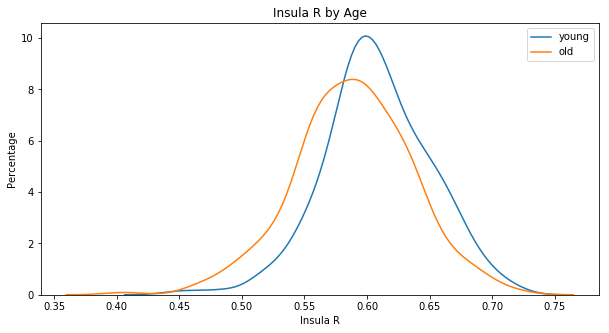

In [131]:
var = 'insula_r'
plt.figure(figsize=figsize)
sns.kdeplot(df_1000.loc[young, var], label='young')
sns.kdeplot(df_1000.loc[old, var], label='old');
plt.title("Insula R by Age")
plt.xlabel('Insula R')
plt.ylabel('Percentage')
plt.savefig(save_name.format('insula_age'))

This model does only slightly better than the age predictive models in the previous section that used the more restricted age groups, which is to say, it performs poorly. This is expected based on the small effect sizes.

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


R^2: 0.5212765957446809
Root Mean Squared Error: 0.6918984060216639
0.5644459706959708
[[26 58]
 [32 72]]


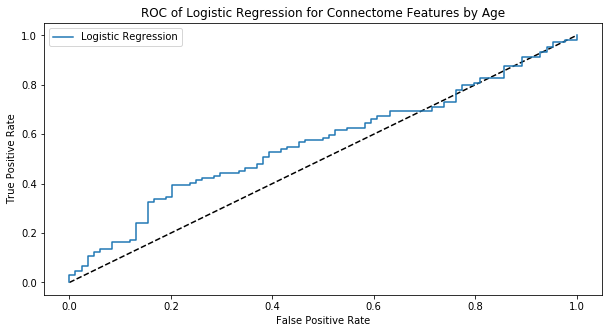

In [198]:
features.append('young')
temp = df_1000.drop(list(set(df_1000.columns).difference(set(features))), axis=1).dropna()
features_norm.pop()

y = temp['young']
X = temp.drop('young', axis=1)

y.mean()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state=42)

logreg = linear_model.LogisticRegression()
logreg.fit(X_train,y_train)

y_pred = logreg.predict(X_test)
y_pred_prob = logreg.predict_proba(X_test)[:,1]

fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred_prob)

plt.figure(figsize=figsize)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='Logistic Regression')
plt.title("ROC of Logistic Regression for Connectome Features by Age")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.savefig(save_name.format('roc_age_conn'))
                 
print("R^2: {}".format(logreg.score(X_test, y_test)))

rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))

print("Root Mean Squared Error: {}".format(rmse))

print(metrics.roc_auc_score(y_test,y_pred_prob))

print(metrics.confusion_matrix(y_test,y_pred))